# Notebook Set-up

In [ ]:
!pip install timm

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics

import timm
from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
import random
import math

from datetime import date
import time
import csv
import h5py
import os
import warnings
warnings.filterwarnings("ignore", message="xFormers is not available.*")

In [2]:
!nvidia-smi

# Run the following in a terminal to monitor VRAM during training
# watch -n 0.5 nvidia-smi

Tue Sep  2 17:49:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:03:00.0 Off |                    0 |
| N/A   29C    P0             54W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing

### Define Dataset Class

In [4]:
class ReflectiveAugmentor:
    def __init__(self, rotation=True, flip=True, max_angle=180, pad_margin=0.01): # Extra padding beyond what's necessary 
        self.rotation = rotation
        self.flip = flip
        self.max_angle = max_angle
        self.pad_margin = pad_margin

    def __call__(self, image):

        if self.flip:
            if random.random() > 0.5:
                image = TF.hflip(image)
            if random.random() > 0.5:
                image = TF.vflip(image)

        if self.rotation:
            angle = random.uniform(-self.max_angle, self.max_angle)
            
            # Compute padding
            _, h, w = image.shape
            pad_r = self.pad_margin + self.pad_ratio(angle)
            pad_h = int(pad_r * h)
            pad_w = int(pad_r * w)

            # Reflect padded image
            image = F.pad(image, (pad_w, pad_w, pad_h, pad_h), mode='reflect')

            # Rotate
            image = TF.rotate(image, angle, interpolation=T.InterpolationMode.BILINEAR, fill=None)

            # Center crop back to original size
            image = TF.center_crop(image, (h, w))

        return image

    @staticmethod
    def pad_ratio(deg):
        if deg % 90 == 0: return 0
        cosx = np.cos(np.radians(deg % 90))
        cosx90 = np.cos(np.radians(90 + deg % 90))
        return (np.emath.sqrt(2)/2) * cosx * np.emath.sqrt((1 - cosx)/(1 - cosx90))
    
class LensDataset(Dataset):
    def __init__(self, 
                 X, 
                 y, 
                 target_size=(126,126), 
                 noise_std=0.1, 
                 add_poisson=False, 
                 exp_time_range=(1e2, 1e6), 
                 augmentor=None, 
                 normalize=True,
                 include_ref=False,
                ):
        self.X = torch.from_numpy(X).float().permute(0, 3, 1, 2)  # now (N, C, H, W)
        self.y = torch.from_numpy(y).float()
        self.target_h, self.target_w = target_size
        self.noise_std = float(noise_std)
        self.add_poisson = add_poisson
        self.exp_time_range = exp_time_range  # (min_exp, max_exp)
        self.augmentor = augmentor
        self.normalize = normalize
        self.include_ref = include_ref
        self.IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        self.IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        # ----- Resize and Make 3-Channels -----
        
        image = TF.resize(self.X[idx], [self.target_h, self.target_w], interpolation=T.InterpolationMode.BICUBIC)
        if image.shape[0] == 1: image = image.repeat(3, 1, 1)
        label = self.y[idx]

        # ----- Flip and Rotate -----

        if self.augmentor:
            image = self.augmentor(image)

        # ----- Add Noise -----
        ref_image = image.clone() if self.include_ref else None

        if self.add_poisson:
            low, high = self.exp_time_range
            exp_time = 10.0 ** torch.empty((), dtype=image.dtype).uniform_(
                math.log10(low), math.log10(high)
            )
            sigma = torch.sqrt(torch.clamp(image, min=0.0) / exp_time)
            image = image + torch.randn_like(image) * sigma
            image = image + torch.randn_like(image) * self.noise_std

        # ----- Normalize -----
        
        if self.normalize:
            # clamp to [0,1] just in case augment produced slight out-of-range
            image = image.clamp(0.0, 1.0)
            image = (image - self.IMAGENET_MEAN) / self.IMAGENET_STD

        if self.include_ref:
            return ref_image, image, label # noisy image is for inference, original is for visual reference
        else: 
            return image, label # this is for training since training needs to reference

### Create Dataset

In [5]:
# Define path to dataset
bryce_path = '/pscratch/sd/a/amurr1/Datasets/roman_data_v1.h5'
f = h5py.File(bryce_path, 'r')

# For now, the following bands are available
for key in f.keys():
    print(key)

F129
F184


In [6]:
# Parameters
band = 'F184'
ds_size = 20000
tf_split = 0.5
train_val = 0.9

# Collect a sample of true and false strong lenses
true_lenses_f184, false_lenses_f184 = [], []
for i, uid in enumerate(f[band]):
    if f[band][uid].attrs.get('is_strong_lens', True):
        true_lenses_f184.append(f[band][uid])
    else:
        false_lenses_f184.append(f[band][uid])
true_lenses_f184 = true_lenses_f184[0:int(ds_size*tf_split)]
false_lenses_f184 = false_lenses_f184[0:int(ds_size*(1-tf_split))]

# Assign labels
true_labeled_f184 = [(img, 1) for img in true_lenses_f184]
false_labeled_f184 = [(img, 0) for img in false_lenses_f184]
print(len(true_labeled_f184))
print(len(false_labeled_f184))

# Combine into a train dataset
train_data = true_labeled_f184[:int(len(true_labeled_f184)*train_val)] + false_labeled_f184[:int(len(false_labeled_f184)*train_val)]
xtrain = np.stack([img for img, label in train_data])[..., np.newaxis]  # (N, H, W, C)
ytrain = np.stack([label for img, label in train_data])

# Combine into a validation dataset
val_data = true_labeled_f184[:int(len(true_labeled_f184)*(1-train_val))] + false_labeled_f184[:int(len(false_labeled_f184)*(1-train_val))]
xval = np.stack([img for img, label in val_data])[..., np.newaxis]  # (N, H, W, C)
yval = np.stack([label for img, label in val_data])

# Check shapes
print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)

10000
10000
(18000, 47, 47, 1)
(18000,)
(1998, 47, 47, 1)
(1998,)


In [7]:
train_dataset = LensDataset(xtrain, ytrain, augmentor=ReflectiveAugmentor(), add_poisson=False)
val_dataset = LensDataset(xval, yval, add_poisson=False)

batch_size = 256

seed = 42
def worker_seed_func(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def make_shuffled_dataloader(dataset, seed, epoch):
    g = torch.Generator()
    g.manual_seed(seed + epoch)
    return torch.utils.data.DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        shuffle = True,
        generator = g,
        num_workers = 4,
        pin_memory = True,
        drop_last = True,
        worker_init_fn = worker_seed_func,
    )

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, 
    batch_size = batch_size,
    num_workers = 4,
    pin_memory = True,
    drop_last = False,
)

# Training

##### Create CSV training log

In [8]:
### To resume training, set epoch to last save epoch and set LR to last known LR.
START_EPOCH = 0
lr_stopped_at = 0.0

run_name = "F1"
today = date.today()
d1 = today.strftime("%d_%m_%Y") 
# this WILL override multiple runs on same day because of line 17, 
# rename run name to distinguish between runs on the same day

parent_dir = "_Time_Trials"
save_dir = parent_dir + "/" + d1 + run_name

if START_EPOCH == 0:
    !mkdir {parent_dir}
    !rm -rf {save_dir}
    !mkdir {save_dir}
    print("CREATED DIRECTORY")

mkdir: cannot create directory ‘_Time_Trials’: File exists
CREATED DIRECTORY


In [9]:
log_file = f"{save_dir}/training_log.csv"
log_fields = ["epoch", "train_loss", "train_auc", "train_precision", "train_recall", "val_loss", "val_auc", "val_precision", "val_recall"]

# Initialize CSV
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with open(log_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(log_fields)

##### Model Set Up

In [10]:
class DINOv2RegClassifier(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super().__init__()
        self.backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg', pretrained=True)
        
        # Replace last layer with a binary classifier head
        self.backbone.head = nn.Sequential(
            nn.BatchNorm1d(self.backbone.num_features),
            nn.Linear(self.backbone.num_features, 128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.backbone(x)

In [11]:
auc_metric = torchmetrics.AUROC(task="binary").to(device)
precision_metric = torchmetrics.Precision(task="binary", threshold=0.9).to(device)
recall_metric = torchmetrics.Recall(task="binary", threshold=0.9).to(device)

In [12]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float().squeeze(-1)
            logits = model(x_batch).squeeze(-1)
            probs = torch.sigmoid(logits)
            loss = criterion(logits, y_batch)

            running_loss += loss.item() * x_batch.size(0)

            auc_metric.update(probs, y_batch.int())
            precision_metric.update(probs, y_batch.int())
            recall_metric.update(probs, y_batch.int())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_auc = auc_metric.compute().item()
    epoch_precision = precision_metric.compute().item()
    epoch_recall = recall_metric.compute().item()

    auc_metric.reset()
    precision_metric.reset()
    recall_metric.reset()

    return epoch_loss, epoch_auc, epoch_precision, epoch_recall

##### Train

In [ ]:
model = DINOv2RegClassifier()
model = torch.nn.DataParallel(model).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    threshold=1e-3,
    threshold_mode='rel',
    cooldown=0,
    min_lr=1e-7,
    eps=0.0,
    verbose=True
)
num_pos = sum(int(y) for _, y in train_dataset)
num_neg = len(train_dataset) - num_pos
pos_weight = torch.tensor([num_neg / max(1, num_pos)], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

num_epochs = 160
best_epoch = None

for epoch in range(num_epochs):
    train_loader = make_shuffled_dataloader(train_dataset, seed, epoch)

    # train_loss, train_auc, train_prec, train_rec = train_epoch(model, train_loader, optimizer, criterion, device)
    train_auc_metric = torchmetrics.AUROC(task="binary").to(device)
    train_prec_metric = torchmetrics.Precision(task="binary", threshold=0.5).to(device)
    train_rec_metric = torchmetrics.Recall(task="binary", threshold=0.5).to(device)

    step = 0
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for x_batch, y_batch in pbar:
        step += 1
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).float().squeeze(-1)

        optimizer.zero_grad()
        logits = model(x_batch).squeeze(-1)
        probs = torch.sigmoid(logits)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_batch.size(0)

        # update metrics
        train_auc_metric.update(probs, y_batch.int())
        train_prec_metric.update(probs, y_batch.int())
        train_rec_metric.update(probs, y_batch.int())

        # push all four stats into the progress bar
        pbar.set_postfix({
            "loss": f"{running_loss/(step * x_batch.size(0)):.4f}",
            "auc":  f"{train_auc_metric.compute().item():.4f}",
            "prec": f"{train_prec_metric.compute().item():.4f}",
            "rec":  f"{train_rec_metric.compute().item():.4f}",
        })

    # compute final epoch metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_auc = train_auc_metric.compute().item()
    train_prec = train_prec_metric.compute().item()
    train_rec = train_rec_metric.compute().item()

    train_auc_metric.reset()
    train_prec_metric.reset()
    train_rec_metric.reset()
    
    val_loss, val_auc, val_prec, val_rec = validate_epoch(model, val_loader, criterion, device)
    scheduler.step(val_loss)
    cur_lrs = [g['lr'] for g in optimizer.param_groups]

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"[Plateau] best={getattr(scheduler, 'best', float('inf')):.6f} "
          f"bad_epochs={getattr(scheduler, 'num_bad_epochs', -1)} "
          f"lr={cur_lrs}")
    print(f"Train | loss: {train_loss:.4f} AUC: {train_auc:.4f} Prec: {train_prec:.4f} Rec: {train_rec:.4f}")
    print(f"Val   | loss: {val_loss:.4f} AUC: {val_auc:.4f} Prec: {val_prec:.4f} Rec: {val_rec:.4f}")
    if (best_epoch == None or val_auc >= best_epoch[1]):
        if (best_epoch == None): best_epoch = (epoch, val_auc)
        torch.save(model.state_dict(), f"{save_dir}/chkpt_epoch_{epoch}.pt")
        print(f"val_auc of {val_auc:.4f} beat previous best {best_epoch[1]:.4f}. Checkpoint Saved.")
        best_epoch = (epoch, val_auc)
    with torch.no_grad():
        logits, targets = [], []
        for xb, yb in val_loader:
            xb = xb.to(device); yb = yb.to(device).float().squeeze(-1)
            lg = model(xb).squeeze(-1)
            logits.append(lg); targets.append(yb)
        logits = torch.cat(logits); targets = torch.cat(targets)
        losses = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        print(f"val loss mean={losses.mean():.4f} median={losses.median():.4f} "
              f"p90={losses.kthvalue(int(0.9*len(losses))).values.item():.4f} "
              f"logit_mean={logits.mean().item():.3f} prob_mean={torch.sigmoid(logits).mean().item():.3f}")
        print("--------")
        
    with open(log_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch + 1,
            train_loss,
            train_auc,
            train_prec,
            train_rec,
            val_loss,
            val_auc,
            val_prec,
            val_rec,
        ])

Using cache found in /global/homes/a/amurr1/.cache/torch/hub/facebookresearch_dinov2_main


Epoch 1/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 1/160
[Plateau] best=0.693587 bad_epochs=0 lr=[0.01]
Train | loss: 0.6909 AUC: 0.4992 Prec: 0.4990 Rec: 0.5420
Val   | loss: 0.6936 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.
val loss mean=0.6936 median=0.6639 p90=0.7233 logit_mean=0.059 prob_mean=0.515
--------


Epoch 2/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 2/160
[Plateau] best=0.693587 bad_epochs=1 lr=[0.01]
Train | loss: 2.6118 AUC: 0.4970 Prec: 0.4900 Rec: 0.1960
Val   | loss: 0.6932 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.
val loss mean=0.6932 median=0.6890 p90=0.6973 logit_mean=-0.008 prob_mean=0.498
--------


Epoch 3/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 3/160
[Plateau] best=0.693587 bad_epochs=2 lr=[0.01]
Train | loss: 0.6901 AUC: 0.4989 Prec: 0.5067 Rec: 0.1013
Val   | loss: 0.6931 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.
val loss mean=0.6931 median=0.6918 p90=0.6945 logit_mean=0.003 prob_mean=0.501
--------


Epoch 4/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 4/160
[Plateau] best=0.693587 bad_epochs=3 lr=[0.01]
Train | loss: 0.6901 AUC: 0.4987 Prec: 0.4997 Rec: 0.9856
Val   | loss: 0.6931 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.
val loss mean=0.6931 median=0.6921 p90=0.6942 logit_mean=-0.002 prob_mean=0.499
--------


Epoch 5/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 5/160
[Plateau] best=0.693587 bad_epochs=0 lr=[0.005]
Train | loss: 0.6901 AUC: 0.4923 Prec: 0.0000 Rec: 0.0000
Val   | loss: 0.6932 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.
val loss mean=0.6932 median=0.6883 p90=0.6980 logit_mean=-0.010 prob_mean=0.498
--------


Epoch 6/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 6/160
[Plateau] best=0.693587 bad_epochs=1 lr=[0.005]
Train | loss: 0.6901 AUC: 0.4952 Prec: 0.4982 Rec: 0.5550
Val   | loss: 0.6931 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.
val loss mean=0.6931 median=0.6931 p90=0.6932 logit_mean=0.000 prob_mean=0.500
--------


Epoch 7/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 7/160
[Plateau] best=0.693587 bad_epochs=2 lr=[0.005]
Train | loss: 0.6901 AUC: 0.4913 Prec: 0.5156 Rec: 0.0147
Val   | loss: 0.6931 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.
val loss mean=0.6931 median=0.6909 p90=0.6954 logit_mean=-0.005 prob_mean=0.499
--------


Epoch 8/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 8/160
[Plateau] best=0.693587 bad_epochs=3 lr=[0.005]
Train | loss: 0.6901 AUC: 0.4908 Prec: 0.4883 Rec: 0.3211
Val   | loss: 0.6931 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.
val loss mean=0.6931 median=0.6920 p90=0.6943 logit_mean=-0.002 prob_mean=0.499
--------


Epoch 9/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 9/160
[Plateau] best=0.693587 bad_epochs=0 lr=[0.0025]
Train | loss: 0.6901 AUC: 0.4944 Prec: 0.4984 Rec: 0.6555
Val   | loss: 0.6931 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.
val loss mean=0.6931 median=0.6922 p90=0.6941 logit_mean=-0.002 prob_mean=0.500
--------


Epoch 10/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 10/160
[Plateau] best=0.693587 bad_epochs=1 lr=[0.0025]
Train | loss: 0.6901 AUC: 0.4940 Prec: 0.4883 Rec: 0.0279
Val   | loss: 0.6931 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.
val loss mean=0.6931 median=0.6929 p90=0.6934 logit_mean=0.000 prob_mean=0.500
--------


Epoch 11/160:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 11/160
[Plateau] best=0.693587 bad_epochs=2 lr=[0.0025]
Train | loss: 0.6901 AUC: 0.4938 Prec: 0.4975 Rec: 0.5408
Val   | loss: 0.6931 AUC: 0.5000 Prec: 0.0000 Rec: 0.0000
val_auc of 0.5000 beat previous best 0.5000. Checkpoint Saved.


In [ ]:
torch.save(model.state_dict(), f"{save_dir}/endrun.pt")

In [12]:
model = DINOv2RegClassifier()
model = torch.nn.DataParallel(model).to(device)

Using cache found in /global/homes/a/amurr1/.cache/torch/hub/facebookresearch_dinov2_main


In [13]:
model.load_state_dict(torch.load("/pscratch/sd/a/amurr1/Roman-lens-search/alexisMurray/TransformerExploration/DINOv2Registers_pt/_Time_Trials/22_08_2025F1/chkpt_epoch_39.pt"))
model.to(device)
model.eval()

DataParallel(
  (module): DINOv2RegClassifier(
    (backbone): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=384, out_features=1536, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=1536, out_features=384, bias=True)
            (drop): Dropout(p=0.0, in

In [59]:
import math
from typing import Tuple, Optional

"""
DINOv2-SPECIFIC ATTENTION MAP EXTRACTION (CLS → PATCH)
=====================================================

This version accounts for additional register tokens beyond CLS and patches.
The registers (special tokens added in DINOv2) should not be included when
computing CLS→patch attention maps. We explicitly slice them out.
"""


def _resolve_backbone(module: nn.Module) -> nn.Module:
    return getattr(module, "backbone", module)


def extract_dinov2_cls_attn_maps(
    model: nn.Module,
    images: torch.Tensor,
    block_index: int = -1,
    head_fusion: str = "mean",   # "mean" or "max"
    upsample_to: Optional[Tuple[int, int]] = None,
) -> torch.Tensor:
    """Compute CLS→patch attention heatmaps from a specific transformer block.

    Tailored for your `DinoVisionTransformer` with `NestedTensorBlock` +
    `MemEffAttention`. **Accounts for register tokens** by excluding them from
    the patch attention slice.

    Token layout assumed by DINOv2 with registers:
        [ CLS ] [ REG ... REG ] [ PATCH ... PATCH ]

    We infer the number of register tokens by:
        T = 1 + R + P, with P a perfect square (patch grid).  
        We choose P as the largest square ≤ (T-1), and set R = (T-1) - P.

    Args:
        model: Your `DINOv2RegClassifier` or the backbone itself. Can be DataParallel.
        images: (B, 3, H, W) normalized as during training.
        block_index: which transformer block to tap (default last block, -1).
        head_fusion: combine heads via "mean" (default) or "max".
        upsample_to: target (H, W) for the heatmap; defaults to input size.

    Returns:
        heatmaps: (B, 1, H, W) in [0, 1].
    """
    # Unwrap DataParallel and resolve backbone
    net = model.module if isinstance(model, nn.DataParallel) else model
    vit = _resolve_backbone(net)

    # Grab the desired transformer block and its MemEffAttention
    assert hasattr(vit, "blocks"), "Backbone missing `.blocks`."
    blk = vit.blocks[block_index]
    assert hasattr(blk, "attn"), "Block missing `.attn`."
    attn_mod = blk.attn  # MemEffAttention

    # Capture the input to attention: shape (B, T, C)
    attn_input = {}

    def _pre_hook(_module, inputs):
        attn_input["x"] = inputs[0].detach()

    handle = attn_mod.register_forward_pre_hook(_pre_hook)

    with torch.no_grad():
        net.eval()
        _ = net(images)

    handle.remove()
    assert "x" in attn_input, "Failed to capture attention input."

    x = attn_input["x"]  # (B, T, C)
    B, T, C = x.shape

    # The MemEffAttention has Linear qkv and num_heads. Head dimension = C / num_heads.
    assert hasattr(attn_mod, "qkv"), "MemEffAttention missing Linear `qkv`."
    assert hasattr(attn_mod, "num_heads"), "MemEffAttention missing `num_heads`."

    num_heads: int = attn_mod.num_heads
    head_dim: int = C // num_heads
    scale = 1.0 / math.sqrt(head_dim)

    # Project x → qkv: (B, T, 3*C)
    qkv = attn_mod.qkv(x)
    # Reshape to (3, B, heads, T, head_dim)
    qkv = qkv.reshape(B, T, 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]

    # Scaled dot-product attention: (B, heads, T, T)
    attn = torch.matmul(q, k.transpose(-2, -1)) * scale
    attn = attn.softmax(dim=-1)

    # -----------------------------
    # Exclude register tokens:
    # tokens = [CLS][REG x R][PATCH x P], with P a perfect square.
    # We infer R and P from T by taking P as the largest square ≤ (T-1).
    # -----------------------------
    tokens_excl_cls = T - 1
    grid = int(math.isqrt(tokens_excl_cls))   # largest integer s.t. grid^2 ≤ tokens_excl_cls
    P = grid * grid                            # number of patch tokens
    R = tokens_excl_cls - P                     # number of register tokens
    assert P > 0 and R >= 0, "Invalid token decomposition (R,P)."

    # CLS attends to *only* the patch tokens: columns [1+R : 1+R+P)
    patch_cols_start = 1 + R
    patch_cols_end = 1 + R + P
    cls_to_patch = attn[:, :, 0, patch_cols_start:patch_cols_end]  # (B, heads, P)

    # Fuse heads
    if head_fusion == "mean":
        cls_to_patch = cls_to_patch.mean(dim=1)  # (B, P)
    elif head_fusion == "max":
        cls_to_patch = cls_to_patch.max(dim=1).values
    else:
        raise ValueError("head_fusion must be 'mean' or 'max'")

    # Map to 2D patch grid (grid x grid = P)
    maps = cls_to_patch.reshape(B, 1, grid, grid)

    # Normalize to [0,1] per image for visualization
    maps = maps - maps.amin(dim=(2, 3), keepdim=True)
    maps = maps / maps.amax(dim=(2, 3), keepdim=True).clamp_min(1e-6)

    # Upsample to image size
    H, W = images.shape[-2:] if upsample_to is None else upsample_to
    heatmaps = F.interpolate(maps, size=(H, W), mode="BICUBIC", align_corners=False)
    return heatmaps.clamp(0, 1)


def denormalize_imagenet(x: torch.Tensor) -> torch.Tensor:
    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
    return (x * std + mean).clamp(0.0, 1.0)


def overlay_heatmap_on_rgb(rgb: torch.Tensor, heatmap: torch.Tensor, alpha: float = 0.45) -> torch.Tensor:
    assert rgb.ndim == 3 and rgb.shape[0] == 3, "rgb must be (3,H,W)"
    assert heatmap.ndim == 3 and heatmap.shape[0] == 1, "heatmap must be (1,H,W)"
    heat = heatmap.clamp(0, 1)               # (1,H,W)
    black = torch.zeros_like(rgb)             # (3,H,W)
    return (heat * rgb + (1 - heat) * black).clamp(0, 1)

# Visualize Results

In [14]:
path_results = f"/pscratch/sd/a/amurr1/Roman-lens-search/alexisMurray/TransformerExploration/DINOv2Registers_pt/_Time_Trials/22_08_2025F1/training_log.csv"

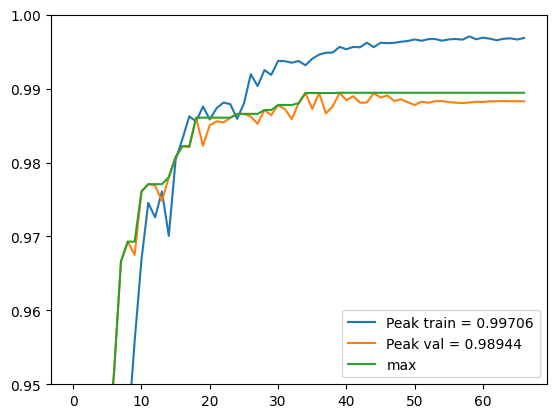

In [15]:
metric = ""
df = pd.read_csv(path_results)
val_auc_max = max(df["val_auc" + metric])
train_auc_max = max(df["train_auc" + metric])
largest = [max(df["val_auc" + metric][:i+1]) for i in range(len(df))]
plt.plot(df["train_auc" + metric][:100],label='Peak train = {:.5f}'.format(train_auc_max))
plt.plot(df["val_auc" + metric][:100], label='Peak val = {:.5f}'.format(val_auc_max))
plt.plot(largest, label='max')
plt.legend()
plt.ylim(0.95,1)
plt.show()

In [66]:
images, labels = next(iter(val_loader))
images_gpu = images.to(device, non_blocking=True)
labels = labels.numpy()

with torch.no_grad():
    heatmaps_gpu = extract_dinov2_cls_attn_maps(
        model, 
        images_gpu, 
        block_index=-1, 
        head_fusion="mean"
    )
    
heatmaps = heatmaps_gpu.detach().cpu()
images = denormalize_imagenet(images).detach().cpu()

num_imgs = 5
pos_idx = np.where(labels == 1)[0]
neg_idx = np.where(labels == 0)[0]
pos_samples = np.random.choice(pos_idx, size=num_imgs, replace=False)
neg_samples = np.random.choice(neg_idx, size=num_imgs, replace=False)

pos_imgs = images[pos_samples]
neg_imgs = images[neg_samples]
pos_hmaps = heatmaps[pos_samples]
neg_hmaps = heatmaps[neg_samples]

pos_overs = []
for i in range(len(pos_imgs)):
    pos_overs.append(overlay_heatmap_on_rgb(pos_imgs[i], pos_hmaps[i]))
neg_overs = []
for i in range(len(neg_imgs)):
    neg_overs.append(overlay_heatmap_on_rgb(neg_imgs[i], neg_hmaps[i]))

pos_imgs = pos_imgs.permute(0, 2, 3, 1)
neg_imgs = neg_imgs.permute(0, 2, 3, 1)
pos_overs = np.array(pos_overs).transpose(0, 2, 3, 1)
neg_overs = np.array(neg_overs).transpose(0, 2, 3, 1)

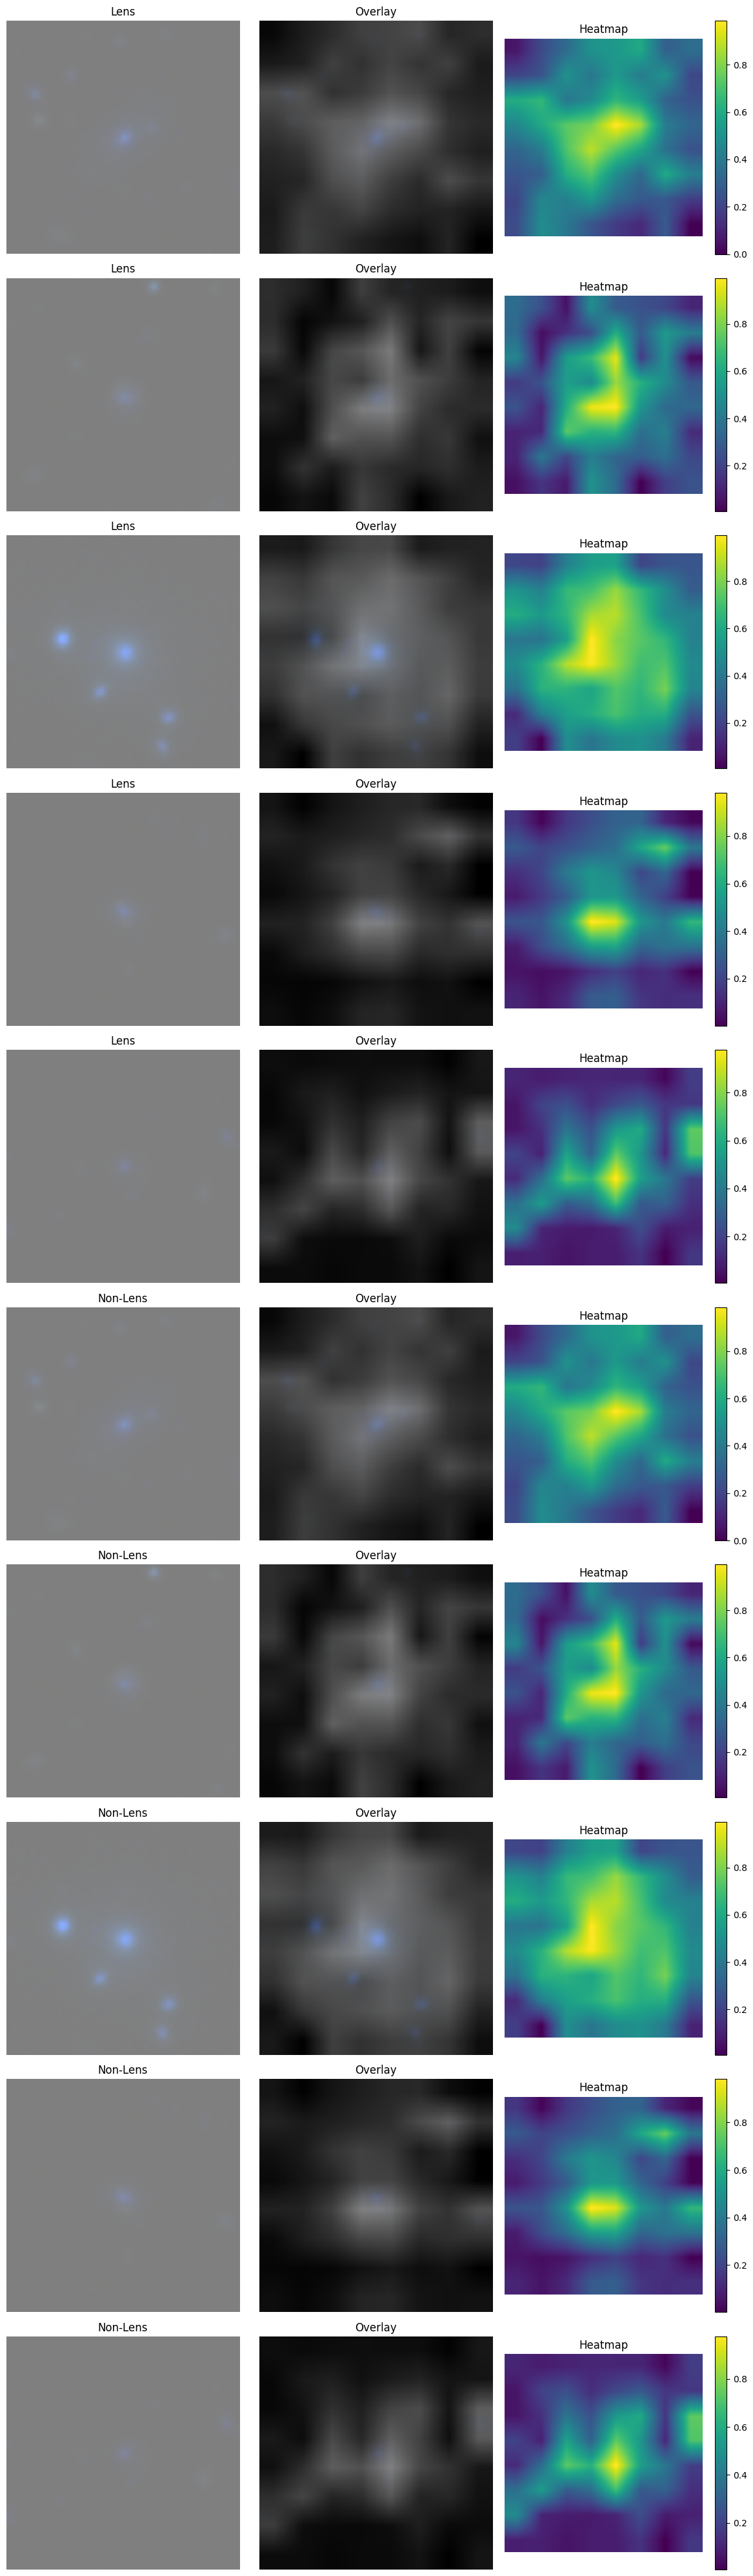

In [67]:
plt.figure(figsize=(12,8*num_imgs))
for i in range(num_imgs):
    titles = ["Lens", "Overlay", "Heatmap"]
    views = [pos_imgs[i], pos_overs[i], pos_hmaps[i,0]]
    for j in range(3):
        plt.subplot(2*num_imgs,3,j+1+3*i); 
        plt.title(titles[j]);     
        plt.imshow(views[j]);                     
        plt.axis("off")
        if j==2: plt.colorbar()
for i in range(num_imgs):
    titles = ["Non-Lens", "Overlay", "Heatmap"]
    views = [pos_imgs[i], pos_overs[i], pos_hmaps[i,0]]
    for j in range(3):
        plt.subplot(2*num_imgs,3,j+1+3*(i+num_imgs)); 
        plt.title(titles[j]);     
        plt.imshow(views[j]);                     
        plt.axis("off")
        if j==2: plt.colorbar()
plt.tight_layout(); plt.show()

In [ ]:
model.eval()
images, labels = next(iter(val_loader))          # (B,3,H,W), already normalized
images = images.to(device)

heatmaps = extract_cls_attn_maps(model, images)  # (B,1,H,W), values in [0,1]